In [1]:
import numpy as np
from tqdm.notebook import tqdm
import astropy.constants as const
import pylab as plt
from astropy.modeling import models
from astropy import units as u
from astropy.visualization import quantity_support

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "12",
      "figure.figsize" : [16,8]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

# Build a model that can explain the emission of galaxies in the optical band 

## Assumptions:  

1) the emission is only due to stars (no bremsstrahlung or so)

2) stars are perfect black bodies

3) IMF: $\xi(M) \propto M^{-2.35}$

4) all the stars are born in the same moment, live on the MS and disappear

## Functions

In [2]:
#return the maximum mass as a function of the age of the stellar population
def max_mass(t, M_sun):
    t_sun = 1e10 * u.yr #10 Gy
    return M_sun * ((t_sun / t).value)**(1 / 2.5)

In [3]:
#scale factor and temperature
def scale_and_temperature(M, M_sun):
    L_sun = const.L_sun.cgs.value
    R_sun = const.R_sun.cgs.value
    sigma = const.sigma_sb.cgs.value
    eta = 3.5 #exponent of the mass-luminosity relation
    xi = 0 #exponent of the mass-radius relation
    
    if (M >= 1.2 * M_sun): 
        xi = 0.56 #cno cycle
    else:
        xi = 0.79 #pp chain
        
    R = R_sun * (M/M_sun)**xi
    L = L_sun * (M/M_sun)**eta
    
    #outputs
    scale_factor = M**(-2.35) * R**2 
    T = (L / (4 * np.pi * R**2 * sigma))**(1/4)
    
    return scale_factor, T

In [4]:
def norm_IMF(M_i, M_f):
    return 1.35 / (M_i ** (-1.35) - M_f ** (-1.35))

In [5]:
def k(l):
    l = l.to(u.micron)  
    Rv = 4.05
    if l >= 0.12 * u.micron and l <= 0.63 * u.micron:
        return 2.659 * (-2.156 + 1.509 / l.value - 0.198 / l.value**2 + 0.011 / l.value**3 ) + Rv
    if l >= 0.63 * u.micron and l <= 2.2 * u.micron:
        return 2.659 * (-1.857 + 1.040 / l.value) + Rv

In [6]:
def exponent(l, E):
    A = E*k(l)
    return -0.4 * A

# different ages 

In [7]:
#global values
M_sun = const.M_sun.cgs.value
M_min = 0.1 * M_sun

#wavelenght array
wave = np.arange(4000, 7000, 1) * u.AA
ages = np.logspace(8, 10.146, 10) * u.yr

In [8]:
#test values taken directly 
test_lambda = np.arange(4000, 7500, 500) * u.AA
G1_test = [1.2, 1.2, 1.1, 1, 1, 1, 1]
G2_test = [0.6, 0.8, 0.95, 1, 1, 0.9, 1]
G3_test = [0.3, 0.7, 0.9, 1, 0.9, 1, 1]

  0%|          | 0/10 [00:00<?, ?it/s]

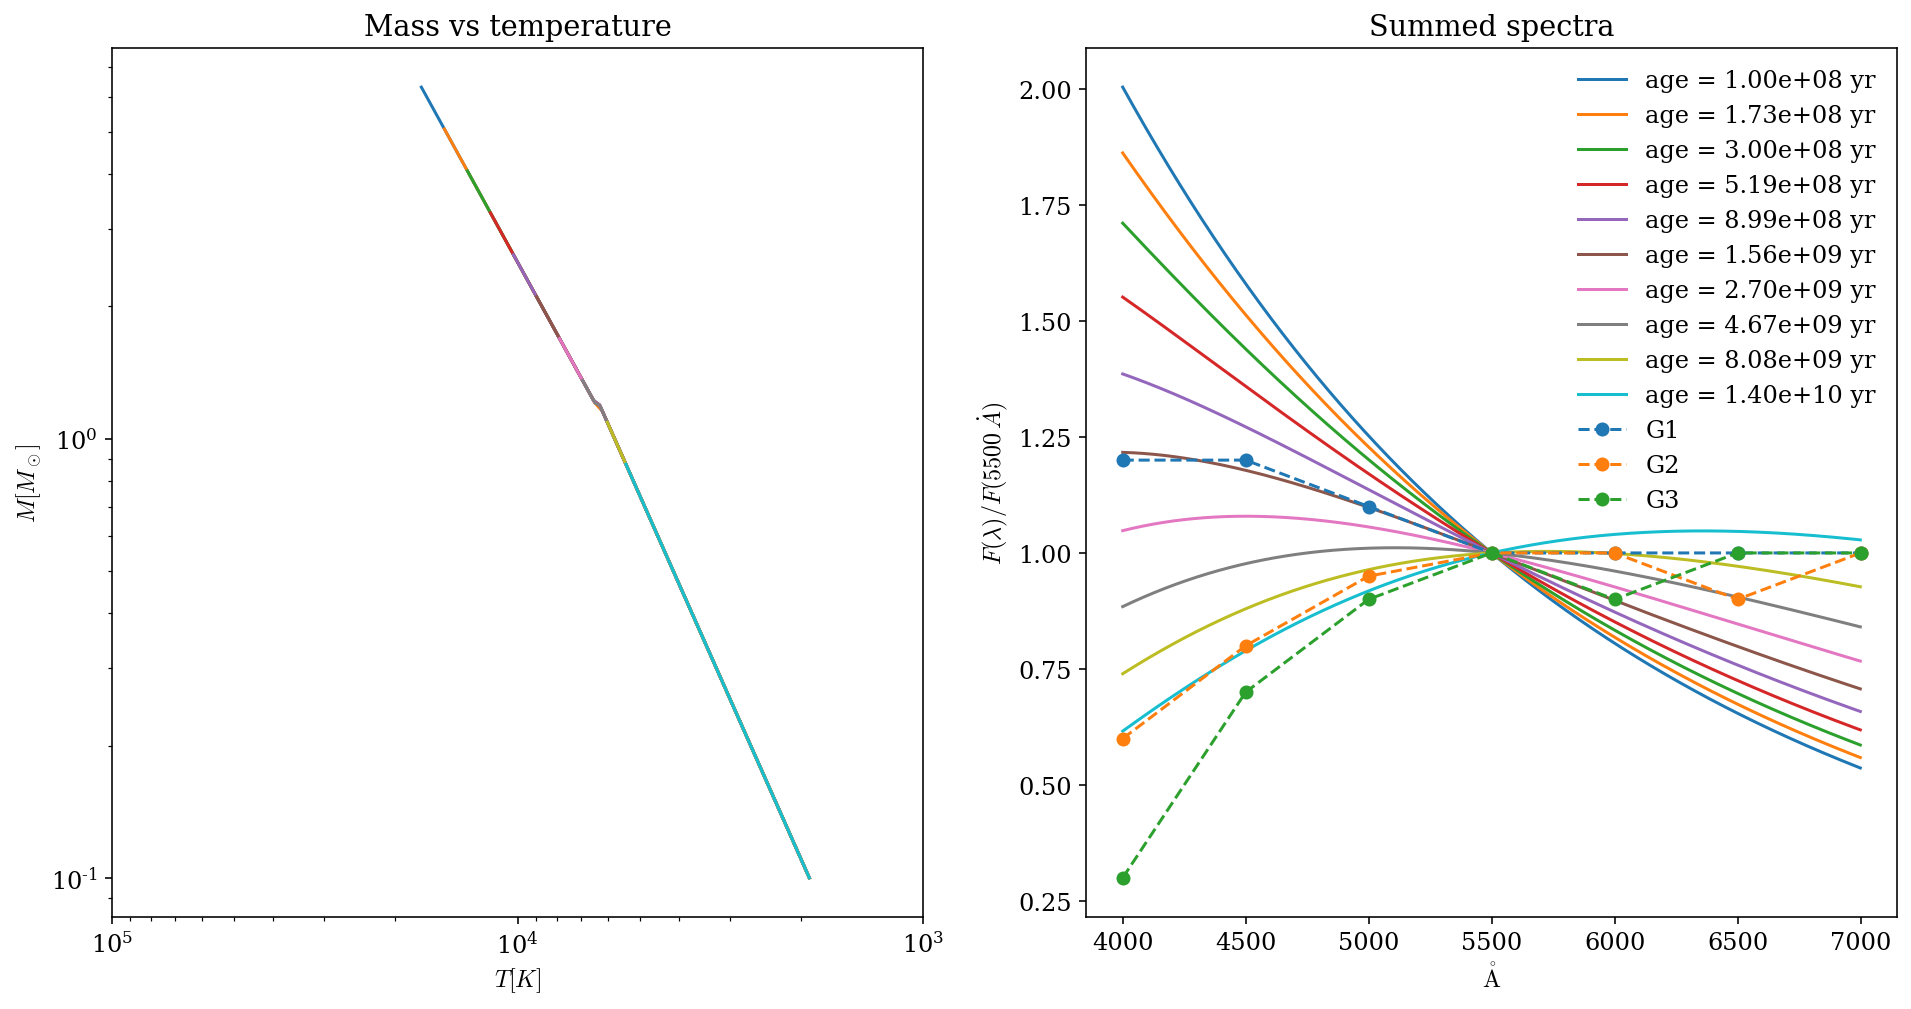

In [9]:
with quantity_support():
    fig, axs = plt.subplots(1, 2)
    for age in tqdm(ages): 
        M_max = max_mass(age, M_sun)
        M_array = np.linspace(M_min, M_max, 100)
        scale_factor_array, temp_array = np.hsplit(np.array([scale_and_temperature(M, M_sun) for M in M_array]), 2)
        
        axs[0].plot(temp_array, M_array / M_sun)
        
        bb = np.sum([models.BlackBody(temperature = T * u.K, scale = scale_factor * u.erg / (u.cm**2 * u.AA * u.s * u.sr)) for T,scale_factor in zip(temp_array, scale_factor_array)])
        
        flux = bb(wave)
        
        axs[1].plot(wave, flux / bb(5500 * u.AA), label = 'age = {:.2e}'.format(age)) #normalize to F(5500 A)
        
    axs[0].set_ylabel("$M [M_\odot]$")
    axs[0].set_xlabel("$T [K]$")
    axs[0].set_title("Mass vs temperature")
    axs[0].loglog()
    axs[0].set_xlim(left = 1e5, right = 1e3)
    
    [axs[1].plot(test_lambda, G, marker = 'o', ls = '--', label = string) for G, string in zip((G1_test, G2_test, G3_test), ('G1', 'G2', 'G3') )]
    axs[1].set_ylabel("$F(\lambda) / F(5500 \, \dot{A})$")
    axs[1].legend(frameon = False)
    axs[1].set_title("Summed spectra")
    plt.show()

Only the galaxy with age $\tau \sim 10\, Gyr$ seems to reproduce the expected behaviour. Anyway, there is **not** a perfect model. What assumptions of the model can I relax? We assumed that all the stars forms in the same moment $\implies$ these galaxies contain only **one population** of stars. What if there is a second one?

# two bursts galaxy history

We have to sum up TWO different populations of stars: $f_{tot} = Af_1 + Bf_2$

In [10]:
age_1 = 1e10 * u.yr #fix the initial age of the first population
ages_2 = np.logspace(8, np.log10(age_1.value / 2), 5) #possible ages of the second

In [11]:
M_max_1 = max_mass(age, M_sun)
M_array = np.linspace(M_min, M_max_1, 100)

scale_factor_array, temp_array = np.hsplit(np.array([scale_and_temperature(M, M_sun) for M in M_array]), 2)
                
bb_1 = np.sum([models.BlackBody(temperature = T * u.K, scale = scale_factor * u.erg / (u.cm**2 * u.AA * u.s * u.sr)) for T,scale_factor in zip(temp_array, scale_factor_array)])
        
flux_1 = bb_1(wave)

A = norm_IMF(M_min, M_max_1) #first coefficient of the linear combination

  0%|          | 0/5 [00:00<?, ?it/s]

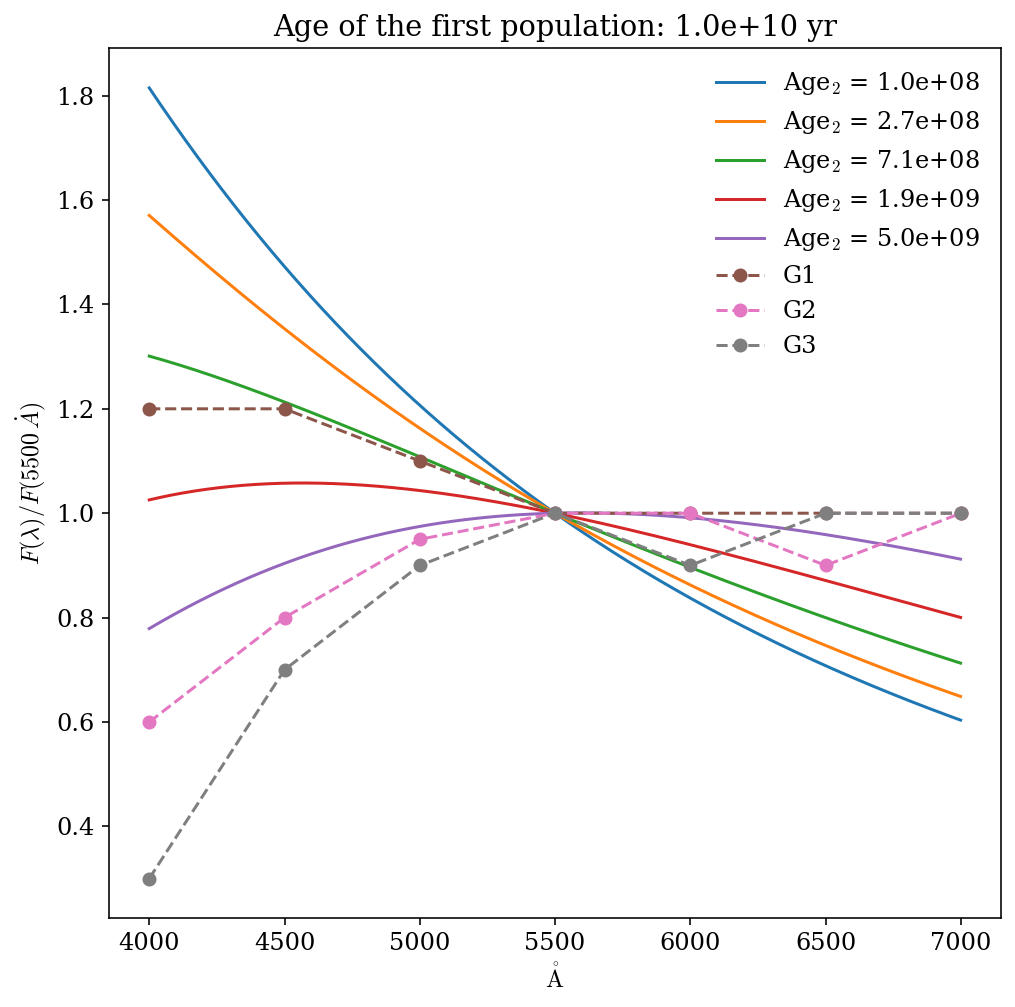

In [12]:
fig = plt.figure(figsize = (8,8))
for age_2 in tqdm(ages_2): 
    M_max_2 = max_mass(age_2, M_sun)
    M_array = np.linspace(M_min, M_max_2, 100)
    scale_factor_array, temp_array = np.hsplit(np.array([scale_and_temperature(M, M_sun) for M in M_array]), 2)
                
    bb_2 = np.sum([models.BlackBody(temperature = T * u.K, scale = scale_factor * u.erg / (u.cm**2 * u.AA * u.s * u.sr)) for T,scale_factor in zip(temp_array, scale_factor_array)])
        
    flux_2 = bb_2(wave)
    B = norm_IMF(M_min, M_max_2) #second coefficient of the linear combination 
    
    flux_tot = (A*flux_1 + B*flux_2) / (A*bb_1(5500 * u.AA) + B*bb_2(5500 * u.AA))
    
    with quantity_support():
        plt.plot(wave, flux_tot, label = r'Age$_2$ = {:.1e}'.format(age_2))

[plt.plot(test_lambda, G, marker = 'o', ls = '--', label = string) for G, string in zip((G1_test, G2_test, G3_test), ('G1', 'G2', 'G3') )]

plt.ylabel("$F(\lambda) / F(5500 \, \dot{A})$")
plt.legend(frameon = False)
plt.title('Age of the first population: {:.1e}'.format(age_1))
plt.show()

# Dust absorption

### free parameters to set

In [13]:
fixed_age = 1e10 * u.yr #age of the first/unique population
fixed_E = 0.3 #fix E(B - V) and change the age

###   age = constant

In [14]:
E_array = np.linspace(0.2, 1, 5) #different values of E(B - V)
fluxes_E = [] #store the fluxes

M_max = max_mass(fixed_age, M_sun)
M_array = np.linspace(M_min, M_max, 100)
scale_factor_array, temp_array = np.hsplit(np.array([scale_and_temperature(M, M_sun) for M in M_array]), 2)

for E in tqdm(E_array):                
    exp = np.array([exponent(l,E) for l in wave]) #compute the exponent (-0.4 * A(lambda)) for each E(B - V)

    bb = np.sum([models.BlackBody(temperature = T * u.K, scale = scale_factor * u.erg / (u.cm**2 * u.AA * u.s * u.sr)) for T,scale_factor in zip(temp_array, scale_factor_array)])
        
    flux = bb(wave) * 10**exp / (bb(5500 * u.AA) * 10**exponent(5500 * u.AA, E)) #normalize to F(5500 A)
    fluxes_E.append(flux)

  0%|          | 0/5 [00:00<?, ?it/s]

### E = constant

In [15]:
ages = np.logspace(8, 10.146, 5)
fluxes_a = []

for age in tqdm(ages): 
    M_max = max_mass(age, M_sun)
    M_array = np.linspace(M_min, M_max, 100)
    scale_factor_array, temp_array = np.hsplit(np.array([scale_and_temperature(M, M_sun) for M in M_array]), 2)
                
    bb = np.sum([models.BlackBody(temperature = T * u.K, scale = scale_factor * u.erg / (u.cm**2 * u.AA * u.s * u.sr)) for T,scale_factor in zip(temp_array, scale_factor_array)])
    
    exp = np.array([exponent(l, fixed_E) for l in wave]) #compute the exponent (-0.4 * A(lambda))
    flux = bb(wave)* 10**exp / (bb(5500 * u.AA) * 10**exponent(5500 * u.AA, fixed_E)) #normalize to F(5500 A)
    
    fluxes_a.append(flux)

  0%|          | 0/5 [00:00<?, ?it/s]

### E = constant + 2 populations

In [16]:
M_max_1 = max_mass(fixed_age, M_sun)
M_array = np.linspace(M_min, M_max_1, 100)

scale_factor_array, temp_array = np.hsplit(np.array([scale_and_temperature(M, M_sun) for M in M_array]), 2)
                
bb_1 = np.sum([models.BlackBody(temperature = T * u.K, scale = scale_factor * u.erg / (u.cm**2 * u.AA * u.s * u.sr)) for T,scale_factor in zip(temp_array, scale_factor_array)])

exp_1 = np.array([exponent(l, fixed_E) for l in wave])

flux_1 = bb_1(wave)* 10**exp_1 

A = norm_IMF(M_min, M_max_1) #first coefficient of the linear combination

In [17]:
ages_2 = np.logspace(7, np.log10(fixed_age.value / 2), 5)
fluxes_pop2 = []

for age in tqdm(ages_2): 
    M_max_2 = max_mass(age, M_sun)
    M_array = np.linspace(M_min, M_max_2, 100)
    scale_factor_array, temp_array = np.hsplit(np.array([scale_and_temperature(M, M_sun) for M in M_array]), 2)
                
    bb_2 = np.sum([models.BlackBody(temperature = T * u.K, scale = scale_factor * u.erg / (u.cm**2 * u.AA * u.s * u.sr)) for T,scale_factor in zip(temp_array, scale_factor_array)])
    
    exp_2 = np.array([exponent(l, fixed_E) for l in wave]) #compute the exponent (-0.4 * A(lambda))
    flux_2 = bb_2(wave)* 10**exp_2
        
    B = norm_IMF(M_min, M_max_2) #second coefficient of the linear combination 
    
    flux_tot = (A*flux_1 + B*flux_2) / ((A*bb_1(5500 * u.AA) + B*bb_2(5500 * u.AA)) * 10**exponent(5500 * u.AA, fixed_E))
    fluxes_pop2.append(flux_tot)

  0%|          | 0/5 [00:00<?, ?it/s]

### plot the result

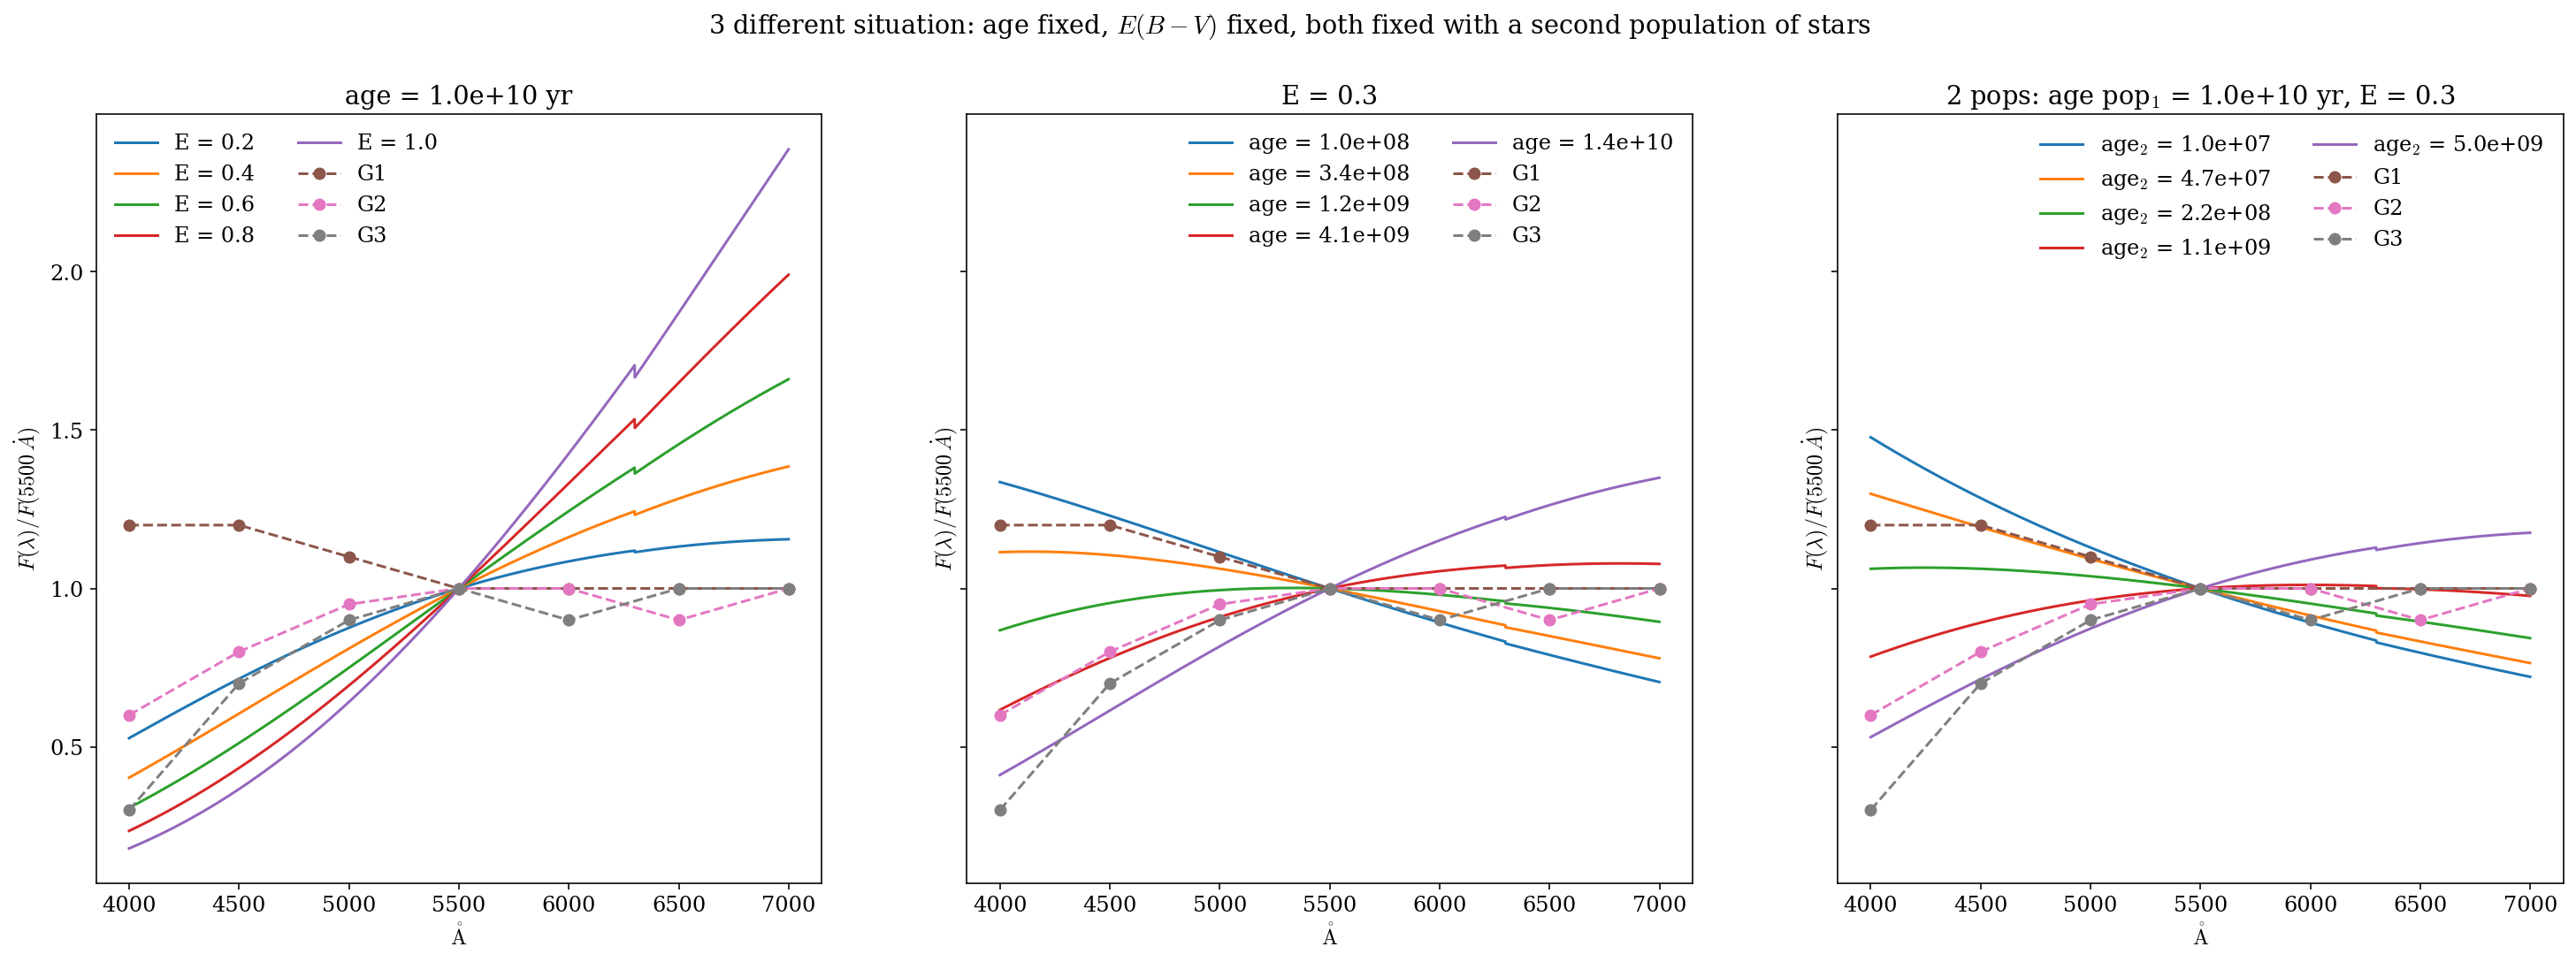

In [18]:
fig, axs = plt.subplots(1, 3, figsize = (25, 8), sharey=True)
with quantity_support():
    [axs[0].plot(wave, flux, label = 'E = %.1f' % E) for flux, E in zip(fluxes_E, E_array)]
    [axs[0].plot(test_lambda, G, marker = 'o', ls = '--', label = string) for G, string in zip((G1_test, G2_test, G3_test), ('G1', 'G2', 'G3') )]
    
    axs[0].set_ylabel("$F(\lambda) / F(5500 \, \dot{A})$")
    axs[0].legend(frameon = False, ncol = 2)
    axs[0].set_title('age = {:.1e}'.format(fixed_age))
    
    [axs[1].plot(wave, flux, label = 'age = {:.1e}'.format(age)) for flux, age in zip(fluxes_a, ages)]
    [axs[1].plot(test_lambda, G, marker = 'o', ls = '--', label = string) for G, string in zip((G1_test, G2_test, G3_test), ('G1', 'G2', 'G3') )]
    
    axs[1].set_ylabel("$F(\lambda) / F(5500 \, \dot{A})$")
    axs[1].legend(frameon = False, ncol = 2)
    axs[1].set_title('E = %.1f' % fixed_E)
    
    [axs[2].plot(wave, flux, label = r'age$_2$ = {:.1e}'.format(age)) for flux, age in zip(fluxes_pop2, ages_2)]
    [axs[2].plot(test_lambda, G, marker = 'o', ls = '--', label = string) for G, string in zip((G1_test, G2_test, G3_test), ('G1', 'G2', 'G3') )]
    
    axs[2].set_ylabel("$F(\lambda) / F(5500 \, \dot{A})$")
    axs[2].legend(frameon = False, ncol = 2)
    axs[2].set_title(r'2 pops: age pop$_1$ = {:.1e}, E = {:.1f}'.format(fixed_age, fixed_E))
    
    fig.suptitle('3 different situation: age fixed, $E(B-V)$ fixed, both fixed with a second population of stars')
    plt.show()

degeneracy: old galaxy == young galaxy with gas. How to break it? stars have absorption lines that depend on the temperature